In [1]:
import qiskit
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

# Key operators

In [2]:
def a_op(qc, q):
    """Construct all equal superposition from initial (s = all 0's) state"""
    list(map(qc.h, q))
    
def mcz_op(qc, controls, target):
    """Multi-controlled-Z operator"""
    return qc.mcu1(np.pi, controls, target)
    
def s0_op(qc, q):
    """Reflection about initial state (s = all 0's)"""
    # flip all qubits
    list(map(qc.x, q))
    # multi-controlled-Z
    qc.mcu1(np.pi, q[:-1], q[-1])
    # flip all qubits
    list(map(qc.x, q))
    
def st_op(qc, q, target):
    """Reflection about target state (t)"""
    # flip qubits corresponding to a zero target bit
    for qbit, tbit in zip(q, target):
        if not tbit:
            qc.x(qbit)
    # multi-controlled-Z
    qc.mcu1(np.pi, q[:-1], q[-1])
    # flip qubits corresponding to a zero target bit
    for qbit, tbit in zip(q, target):
        if not tbit:
            qc.x(qbit)

def grover_op(qc, q, target):
    """Operator for one Grover iteration"""
    a_op(qc, q)
    s0_op(qc, q)
    a_op(qc, q)
    st_op(qc, q, target)

# Construct quantum circuit

In [3]:
# inputs
n = 5
target = [0, 1, 0, 1, 0]

# optimal iterations
niter = int(np.ceil(np.pi*np.sqrt(2**n)/4))
print("Optimal number of iterations = %s" % niter)

# quantum circuit
q = qiskit.QuantumRegister(n, name='q')
c = qiskit.ClassicalRegister(n, name='c')
qc = qiskit.QuantumCircuit(q, c, name='qc')

# initialize
a_op(qc, q)

# Grover iterations
for _ in range(niter):
    grover_op(qc, q, target)
    
# measurement
list(map(lambda x: qc.measure(*x), zip(q, c)))

print("------- operation counts (raw) -------")
for op, count in qc.count_ops().items():
    if op == 'measure':
        continue
    print("%s: %d" % (op, count))
    
print("------- operation counts (decomposed) -------")
for op, count in qc.decompose().count_ops().items():
    if op == 'measure':
        continue
    print("%s: %d" % (op, count))

# qc.draw()

Optimal number of iterations = 5
------- operation counts (raw) -------
x: 80
h: 55
mcu1: 10
------- operation counts (decomposed) -------
cu1: 150
cx: 140
u3: 80
u2: 55


# Qiskit simulation

In [4]:
# qasm simulator
backend = qiskit.BasicAer.get_backend('qasm_simulator')
job = qiskit.execute(qc, backend, shots=4096)
job.result().get_counts()

{'01001': 1, '11000': 2, '11101': 1, '01010': 4091, '01101': 1}

In [5]:
# state vector simulator
backend = qiskit.BasicAer.get_backend('statevector_simulator')
qc.remove_final_measurements()
job = qiskit.execute(qc, backend)
job.result().get_statevector()

array([-0.00513585+6.72205347e-17j, -0.00513585+5.68121938e-17j,
       -0.00513585+1.84314369e-17j, -0.00513585+4.46691295e-17j,
       -0.00513585-3.40439482e-17j, -0.00513585-1.82145965e-17j,
       -0.00513585+6.72205347e-17j, -0.00513585+1.18828558e-16j,
       -0.00513585+1.23165367e-16j, -0.00513585+2.60208521e-17j,
       -0.99959107+3.80251386e-15j, -0.00513585+1.17744356e-16j,
       -0.00513585-6.59194921e-17j, -0.00513585-9.43255890e-17j,
       -0.00513585+9.54097912e-17j, -0.00513585+1.41163123e-16j,
       -0.00513585-1.75856367e-17j, -0.00513585+4.03107593e-17j,
       -0.00513585-1.15141045e-17j, -0.00513585+1.40730667e-17j,
       -0.00513585-3.88359993e-17j, -0.00513585+2.35148309e-17j,
       -0.00513585+3.09866206e-17j, -0.00513585+1.29670580e-16j,
       -0.00513585-9.34570020e-18j, -0.00513585+2.84060969e-17j,
       -0.00513585+1.62414711e-17j, -0.00513585-2.99239800e-17j,
       -0.00513585-3.27416804e-18j, -0.00513585-8.45677695e-18j,
       -0.00513585+7.1535

In [6]:
backend = qiskit.BasicAer.get_backend('unitary_simulator')
qc.remove_final_measurements()
job = qiskit.execute(qc, backend)
job.result().get_unitary()

array([[-0.00513585+6.72205347e-17j, -0.1502343 -1.00613962e-16j,
        -0.20331909+4.57966998e-16j, ..., -0.20331909+5.75928194e-16j,
        -0.1502343 +2.74086309e-16j, -0.1502343 -2.08166817e-17j],
       [-0.00513585+5.68121938e-17j,  0.20331909-2.84494650e-16j,
        -0.20331909+3.88578059e-16j, ...,  0.1502343 -1.56125113e-16j,
        -0.1502343 +5.89805982e-17j,  0.20331909-2.63677968e-16j],
       [-0.00513585+1.84314369e-17j, -0.1502343 +4.61436445e-16j,
         0.1502343 -2.74086309e-16j, ..., -0.20331909+6.66133815e-16j,
         0.20331909-6.80011603e-16j,  0.20331909-5.82867088e-16j],
       ...,
       [-0.00513585-8.45677695e-18j,  0.20331909-5.48172618e-16j,
        -0.20331909+5.82867088e-16j, ..., -0.20331909+4.51028104e-16j,
         0.20331909-3.81639165e-16j, -0.1502343 +6.93889390e-18j],
       [-0.00513585+7.15357819e-17j, -0.1502343 +5.31876544e-16j,
         0.1502343 -3.47995855e-16j, ...,  0.1502343 -4.86773733e-16j,
        -0.1502343 +4.55548711e-16j

# Analysis

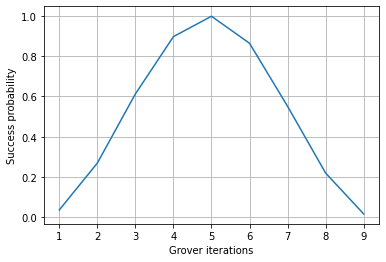

In [7]:
# success rate vs number of iterations

# inputs
n = 5
target = [0, 1, 0, 1, 0]

# simulation parameters
backend = qiskit.BasicAer.get_backend('qasm_simulator')
shots = 4096
niters = list(range(1, 10))

# outputs
res = []

# iterate over number of Grover iterations
for r in niters:
    
    q = qiskit.QuantumRegister(n, name='q')
    c = qiskit.ClassicalRegister(n, name='c')
    qc = qiskit.QuantumCircuit(q, c, name='qc')
    
    # initialize
    a_op(qc, q)
    
    # Grover iterations
    for _ in range(r):
        grover_op(qc, q, target)

    # measure
    list(map(lambda x: qc.measure(*x), zip(q, c)))

    job = qiskit.execute(qc, backend, shots=shots)
    counts = job.result().get_counts().get('01010', 0)
    res.append(counts)
    
# plot
plt.plot(niters, [c/shots for c in res])
plt.xlabel("Grover iterations")
plt.ylabel("Success probability")
plt.grid('on')